In [1]:
import os
import random

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
import tensorflow_datasets as tfds

tf.version.VERSION

'2.8.0'

In [2]:
TARGET_SHAPE = [200, 200]

data = tfds.load('cycle_gan/apple2orange')
train_a = data['trainA']
train_b = data['trainB']
test_a = data['testA']
test_b = data['testB']


def only_image(entry):
    image = entry['image']
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, TARGET_SHAPE)
    return image


size = min(len(train_a), len(train_b))
train_a = train_a.map(only_image).take(size)
train_b = train_b.map(only_image).take(size)
anchor_ds = train_a.shuffle(100).concatenate(train_b.shuffle(100))
positive_ds = train_a.shuffle(100).concatenate(train_b.shuffle(100))
negative_ds = train_b.shuffle(100).concatenate(train_a.shuffle(100))
print('anchor: ', len(anchor_ds))
print('positive: ', len(positive_ds))
print('negative: ', len(negative_ds))

ds = tf.data.Dataset.zip((anchor_ds, positive_ds, negative_ds)).shuffle(2000).batch(32)
ds

anchor:  1990
positive:  1990
negative:  1990


2022-09-14 01:26:38.329327: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.


<BatchDataset element_spec=(TensorSpec(shape=(None, 200, 200, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 200, 200, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 200, 200, 3), dtype=tf.float32, name=None))>

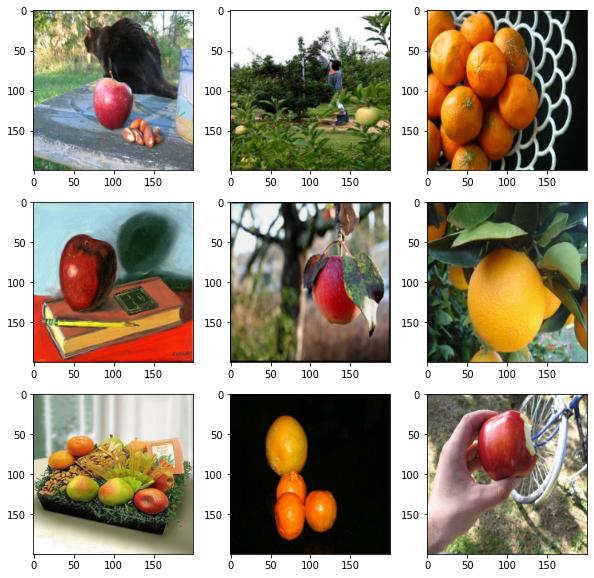

In [3]:
def show_data(ds):
    plt.figure(figsize=(10, 10))
    for anchors, pos, neg in ds.take(1):
        for i in range(3):
            plt.subplot(3, 3, i * 3 + 1)
            plt.imshow(anchors.numpy()[i])
            plt.subplot(3, 3, i * 3 + 2)
            plt.imshow(pos.numpy()[i])
            plt.subplot(3, 3, i * 3 + 3)
            plt.imshow(neg.numpy()[i])


show_data(ds)
plt.show()

In [4]:
class SiameseModel(keras.Model):
    """
    The triplet loss is defined as:
       L(A, P, N) = max(‖f(A) - f(P)‖² - ‖f(A) - f(N)‖² + margin, 0)
    """

    def __init__(self, network, margin=0.5):
        super(SiameseModel, self).__init__()
        self.network = network
        self.margin = margin
        self.loss_tracker = keras.metrics.Mean(name="loss")

        
    def call(self, inputs):
        return self.network(inputs)

    
    def _compute_loss(self, data):
        anchor, positive_example, negative_example = data
        embedding_anchor = self.network(anchor)
        embedding_pos = self.network(positive_example)
        embedding_neg = self.network(negative_example)
        
        pos_distance = tf.reduce_sum(tf.square(embedding_anchor - embedding_pos), -1)
        neg_distance = tf.reduce_sum(tf.square(embedding_anchor - embedding_neg), -1)
        
        loss = tf.maximum(pos_distance - neg_distance + self.margin, 0.0)
        return loss
    
    
    @tf.function
    def _train_step(self, data):
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)
            
        gradients = tape.gradient(loss, self.network.trainable_weights)

        self.optimizer.apply_gradients(zip(gradients, self.network.trainable_weights))

        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}
    
    
    def train_step(self, data):
        return self._train_step(data)
    
        
    def test_step(self, data):
        loss = self._compute_loss(data)

        # Let's update and return the loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}
    

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker]


def create_siamese_network():
    base_cnn = keras.applications.resnet.ResNet50(weights="imagenet", input_shape=TARGET_SHAPE + [3], include_top=False)
    flatten = layers.Flatten()(base_cnn.output)
    dense1 = layers.Dense(512, activation="relu")(flatten)
    dense1 = layers.BatchNormalization()(dense1)
    dense2 = layers.Dense(256, activation="relu")(dense1)
    dense2 = layers.BatchNormalization()(dense2)
    output = layers.Dense(256)(dense2)
    
    embedding = keras.Model(base_cnn.input, output, name="Embedding")
    
    trainable = False
    for layer in base_cnn.layers:
        if layer.name == "conv5_block1_out":
            trainable = True
        layer.trainable = trainable
    
    siamese_model = SiameseModel(base_cnn)
    siamese_model.compile(optimizer=keras.optimizers.Adam(1e-4))
    return siamese_model, base_cnn


keras.backend.clear_session()
siamese_model, base_cnn = create_siamese_network()

In [5]:
siamese_model.fit(ds, epochs=100)

Epoch 1/100


2022-09-14 01:26:49.504134: W tensorflow/core/common_runtime/bfc_allocator.cc:343] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overhead. You may try smaller batch sizes to observe the performance impact. Set TF_ENABLE_GPU_GARBAGE_COLLECTION=false if you'd like to disable this feature.
2022-09-14 01:26:49.578042: W tensorflow/core/common_runtime/bfc_allocator.cc:343] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overhead. You may try smaller batch sizes to observe the performanc

63/63 [==============================] - 21s 189ms/step - loss: 1.9237
Epoch 2/100
63/63 [==============================] - 12s 174ms/step - loss: 0.5250
Epoch 3/100
63/63 [==============================] - 12s 171ms/step - loss: 0.5034
Epoch 4/100
63/63 [==============================] - 12s 171ms/step - loss: 0.5011
Epoch 5/100
63/63 [==============================] - 12s 172ms/step - loss: 0.4925
Epoch 6/100
63/63 [==============================] - 12s 171ms/step - loss: 0.4805
Epoch 7/100
63/63 [==============================] - 12s 172ms/step - loss: 0.4667
Epoch 8/100
63/63 [==============================] - 12s 171ms/step - loss: 0.4564
Epoch 9/100
63/63 [==============================] - 12s 170ms/step - loss: 0.4398
Epoch 10/100
63/63 [==============================] - 12s 170ms/step - loss: 0.4240
Epoch 11/100
63/63 [==============================] - 12s 174ms/step - loss: 0.3987
Epoch 12/100
63/63 [==============================] - 12s 171ms/step - loss: 0.3770
Epoch 13/100


63/63 [==============================] - 12s 168ms/step - loss: 0.0908
Epoch 99/100
63/63 [==============================] - 12s 169ms/step - loss: 0.0961
Epoch 100/100
63/63 [==============================] - 12s 168ms/step - loss: 0.1314
